In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Creating Dataset and Dataloader

In [ ]:
class SARImageData(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []

    data_folders = [
        os.path.join(root_dir, "data", "S1SAR_UnBalanced_400by400_Class_0", "0"),
        os.path.join(root_dir, "data", "S1SAR_UnBalanced_400by400_Class_1", "1")
    ]

    # Scan folders and get image paths
    for folder in data_folders:
      assert os.path.exists(folder) # Folder should exist

      for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        self.image_paths.append(img_path)
        self.labels.append(int(os.path.basename(os.path.dirname(img_path)))) # Append corresponding label(parent folder) to self.labels

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    img_path = self.image_paths[index]
    img = Image.open(img_path).convert("L") # Convert to grayscale if it isn't already
    label = self.labels[index]

    if self.transform:
      img = self.transform(img)

    return img, label

In [ ]:
transform = transforms.ToTensor()

train_data = SARImageData("./CSIRO_Sentinel-1_SAR_Oil_Images/CSIRO_Sentinel-1_SAR_Oil_Images", transform=transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4) # For low-end gpu, batch_size=8 & num_workers=2

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


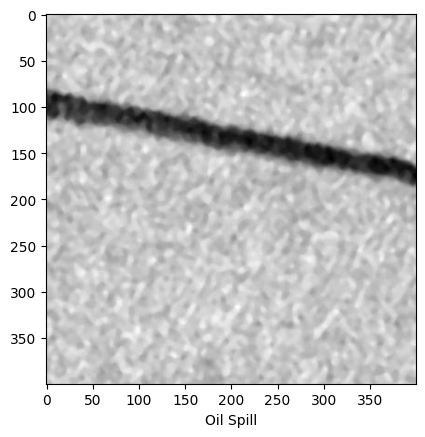

In [ ]:
# Quick test
def plot_random_img(dataloader):
  label_map = {0: "Not an Oil Spill", 1: "Oil Spill"}
  images, labels = next(iter(train_dataloader))
  plt.imshow(images[0].squeeze(), cmap="gray")
  plt.xlabel(label_map.get(labels[0].item()))

plot_random_img(train_dataloader)